## Initial Thoughts

This is a dataset for the credit card fraud transaction detection. I got some initial thoughts after checking it.
1. This is a **binary classification** problem to predict if a transaction is Fraud.
2. **Imbalanced data, with only 1.58% fraud transactions.** I will undersample the non-fraud transaction and use F1-score as the metrics to avoid bias.
3. <span style="color:red">One business purpose should reduce loss to avoid fraud transactions</span>, the percentage of **the amount of predicted fraud transaction <span style="color:red">(True Positive)</span>/the amount of fraud transaction** should be high.
4. <span style="color:red">The other business purpose should be less effect on the non-fraud real transactions</span>, the percentage of **the transactions of predicted fraud transactions <span style="color:red">(False Positive)</span>/real transactions** should be low.

Key words: **binary classification, imbalanced data, adversarial validation, logistic regression, neutral network, early stopping**

In [1]:
import pandas as pd
import json
import joblib
import tqdm
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [ ]:
# the format of the file is special, read all data to dataframe
with open('transactions.txt') as f:
    content = f.read().splitlines()

df = pd.DataFrame.from_records([json.loads(i) for i in content])

In [ ]:
# save the dataframe for faster reading
joblib.dump(df, 'df.joblib')

In [2]:
df = joblib.load('df.joblib')

### EDA

In [3]:
df.shape

(786363, 29)

In [4]:
# quick check the data balance
df.isFraud.value_counts()

False    773946
True      12417
Name: isFraud, dtype: int64

In [5]:
# quick check the data balance
df.isFraud.value_counts() / df.shape[0]

False    0.98421
True     0.01579
Name: isFraud, dtype: float64

Very imbalanced data, we would use F1 as metrics to avoid biased results. And I will undersample the False cases.

In [6]:
# check some cols which seem useless
for col in ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']:
    print(col)
    display(df[col].value_counts() / df.shape[0])

echoBuffer


    1.0
Name: echoBuffer, dtype: float64

merchantCity


    1.0
Name: merchantCity, dtype: float64

merchantState


    1.0
Name: merchantState, dtype: float64

merchantZip


    1.0
Name: merchantZip, dtype: float64

posOnPremises


    1.0
Name: posOnPremises, dtype: float64

recurringAuthInd


    1.0
Name: recurringAuthInd, dtype: float64

In [7]:
# remove some useless columns with one value and identifications, we are looking for a pattern not a specific customer
useless_cols = ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd',
                'accountNumber', 'customerId', 'cardLast4Digits']
df.drop(columns=useless_cols, inplace=True)
df.head()

,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,PURCHASE,0.0,False,False,False
1,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,PURCHASE,0.0,True,False,False
2,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,PURCHASE,0.0,False,False,False
3,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,PURCHASE,0.0,False,False,False
4,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,PURCHASE,0.0,True,False,False


In [8]:
# check duplicated data
df.drop_duplicates().shape

(786363, 20)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
# create features related to CVV and remove the old CVV features
df['correctedCVV'] = df.cardCVV == df.enteredCVV
df.drop(columns=['cardCVV', 'enteredCVV'], inplace=True)
df.head()

,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,correctedCVV
0,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,PURCHASE,0.0,False,False,False,True
1,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,PURCHASE,0.0,True,False,False,True
2,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,PURCHASE,0.0,False,False,False,True
3,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,PURCHASE,0.0,False,False,False,True
4,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,PURCHASE,0.0,True,False,False,True


In [11]:
# calcluate some date realted features and remove date columns
date_cols = ['transactionDateTime', 'currentExpDate',
             'accountOpenDate', 'dateOfLastAddressChange']
for i in date_cols:
    df[i] = pd.to_datetime(df[i])

# create some date features
df['transactionDays'] = (df.transactionDateTime.dt.date -
                         df.accountOpenDate.dt.date).dt.days
df['currentExpDays'] = (df.currentExpDate.dt.date -
                        df.accountOpenDate.dt.date).dt.days
df['addressChangeDays'] = (
    df.dateOfLastAddressChange.dt.date - df.accountOpenDate.dt.date).dt.days
df['transactionDOW'] = df.transactionDateTime.dt.dayofweek
df['transactionWeek'] = df.transactionDateTime.dt.isocalendar().week
df['transactionHour'] = df.transactionDateTime.dt.hour

# remove date_cols
df.drop(columns=date_cols, inplace=True)
df.head()

,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,correctedCVV,transactionDays,currentExpDays,addressChangeDays,transactionDOW,transactionWeek,transactionHour
0,5000.0,5000.0,98.55,Uber,US,US,02,01,rideshare,PURCHASE,0.0,False,False,False,True,518,3001,0,5,32,14
1,5000.0,5000.0,74.51,AMC #191138,US,US,09,01,entertainment,PURCHASE,0.0,True,False,False,True,577,3246,0,1,41,5
2,5000.0,5000.0,7.47,Play Store,US,US,09,01,mobileapps,PURCHASE,0.0,False,False,False,True,605,3793,0,1,45,9
3,5000.0,5000.0,7.47,Play Store,US,US,09,01,mobileapps,PURCHASE,0.0,False,False,False,True,637,3793,0,5,49,2
4,5000.0,5000.0,71.18,Tim Hortons #947751,US,US,02,01,fastfood,PURCHASE,0.0,True,False,False,True,231,5170,0,3,12,21


In [12]:
# check unique values for object columns
for i in df.select_dtypes(include=['object']).columns:
    print(df[i].value_counts())
    print(df[i].unique())
    print('______')

Uber                             25613
Lyft                             25523
oldnavy.com                      16992
staples.com                      16980
alibaba.com                      16959
                                 ...  
Sprint Communications #561941        2
Runners #383214                      2
Curves #849125                       1
EZ Wireless #149871                  1
TMobile Wireless #602341             1
Name: merchantName, Length: 2490, dtype: int64
['Uber' 'AMC #191138' 'Play Store' ... 'ATT #141119' 'EZ Wireless #200746'
 'Runners #747070']
______
US     774709
         4562
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64
['US' '' 'CAN' 'MEX' 'PR']
______
US     778511
MEX      3143
CAN      2426
PR       1559
          724
Name: merchantCountryCode, dtype: int64
['US' 'CAN' '' 'PR' 'MEX']
______
05    315035
09    236481
02    195934
90     19576
80     15283
        4054
Name: posEntryMode, dtype: int64
['02' '09' '05' '80' '90' '']
__

In [13]:
# remove object columns with empty string, this is kind of null values
for i in df.select_dtypes(include=['object']).columns:
    df = df.loc[df[i] != '']

In [14]:
# check the unique number of merchantName col
df.merchantName.nunique()

2489

In [15]:
# it's found that merchantName contains many store with store id like ATT #141119
# find all different store name and combine them
store_names = df.loc[df.merchantName.str.contains(
    ' #'), 'merchantName'].unique().tolist()
store_names = set([i.split('#')[0] for i in store_names])

for i in store_names:
    df.loc[df.merchantName.str.contains(f'{i}#'), 'merchantName'] = i.strip()

# check nunique
df.merchantName.nunique()

205

In [16]:
# check unique values
df.merchantName.unique()

array(['Uber', 'AMC', 'Play Store', 'Tim Hortons', 'In-N-Out',
       'Krispy Kreme', 'Shake Shack', 'Five Guys', "Auntie Anne's",
       'GreenCook', 'Washington Repair', 'Eazy Tire',
       'Convenient Auto Services', 'Shell Auto Body',
       'Fast Auto Services', 'staples.com', 'Convenient Repair',
       'Shell Repair', 'Eazy Repair', 'Fast Repair', 'Eazy Auto Body',
       'Washington Tire', 'target.com', 'Convenient Tire', 'amazon.com',
       'Shell Tire', 'Merchants Auto Body', 'gap.com', 'Fast Tire',
       'sears.com', 'apple.com', 'Merchants Tire', 'Ricks Auto Body',
       'Merchants Auto Services', 'Curves', 'oldnavy.com',
       'Washington Auto Body', 'ebay.com', 'discount.com', 'alibaba.com',
       'CVS', 'Walgreens', 'WSC', 'Universe Massage', 'Powerlifting',
       '1st Sandwitch Bar', 'NYSC', 'Lyft', 'Planet Fitness', 'Golds Gym',
       'Boston Fries', 'South Steakhouse', '53rd Beauty', 'Regal Cinemas',
       "John's Cafe", 'Rock Weights', 'Downtown BBQ', '34th P

In [17]:
# still too many, find the one with major Fraud merchantName
fraudMerchantName = df.loc[df.isFraud == True,
                           'merchantName'].value_counts().reset_index(name='cnt')
fraudMerchantName.head()

,index,cnt
0,Lyft,739
1,ebay.com,629
2,Fresh Flowers,529
3,Uber,494
4,EZ Putt Putt,475


In [18]:
# check distribution
fraudMerchantName.cnt.describe()

count    173.00000
mean      69.16763
std      130.99410
min        1.00000
25%        9.00000
50%       16.00000
75%       45.00000
max      739.00000
Name: cnt, dtype: float64

In [19]:
# find a cutoff to cover at least 80% of all Fraud transactions
fraudMerchantName.loc[fraudMerchantName.cnt >= fraudMerchantName.cnt.quantile(
    q=0.80), 'cnt'].sum() / df.loc[df.isFraud == True].shape[0]

0.8064516129032258

In [20]:
# keep most frequent merchant names with quantile 0.8
high_freq_fraud_mechant_names = fraudMerchantName.loc[fraudMerchantName.cnt >= fraudMerchantName.cnt.quantile(
    q=0.80), 'index']

# use others to replace other merchantName values
df.loc[~df.merchantName.isin(
    high_freq_fraud_mechant_names), 'merchantName'] = 'others'

df.merchantName.nunique()

36

The number of unique values in merchantName changes from 2489 to 36

In [21]:
# check null
df.isnull().sum()

creditLimit                 0
availableMoney              0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
transactionType             0
currentBalance              0
cardPresent                 0
expirationDateKeyInMatch    0
isFraud                     0
correctedCVV                0
transactionDays             0
currentExpDays              0
addressChangeDays           0
transactionDOW              0
transactionWeek             0
transactionHour             0
dtype: int64

In [22]:
# check data types
df.dtypes

creditLimit                 float64
availableMoney              float64
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
transactionType              object
currentBalance              float64
cardPresent                    bool
expirationDateKeyInMatch       bool
isFraud                        bool
correctedCVV                   bool
transactionDays               int64
currentExpDays                int64
addressChangeDays             int64
transactionDOW                int64
transactionWeek              UInt32
transactionHour               int64
dtype: object

In [23]:
# check duplicated data
df.drop_duplicates().shape

(776419, 21)

In [24]:
df.drop_duplicates(inplace=True)

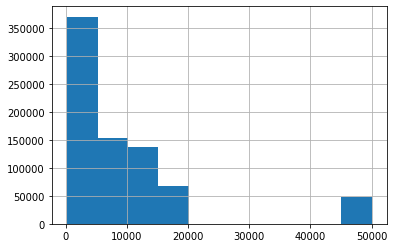

In [25]:
# check data distribution for numeric columns
col = 'creditLimit'
df[col].hist();

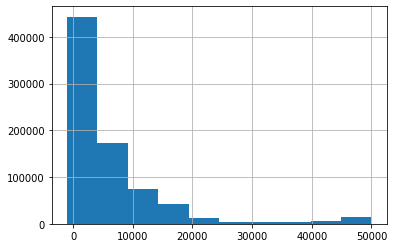

In [26]:
col = 'availableMoney'
df[col].hist();

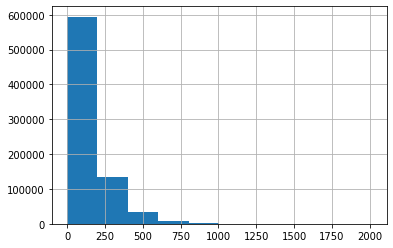

In [27]:
col = 'transactionAmount'
df[col].hist();

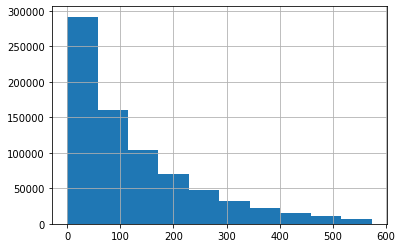

In [28]:
# remove extrem values by quantile 0.98
col = 'transactionAmount'
df = df.loc[df[col] <= df[col].quantile(q=0.98)]
df[col].hist();

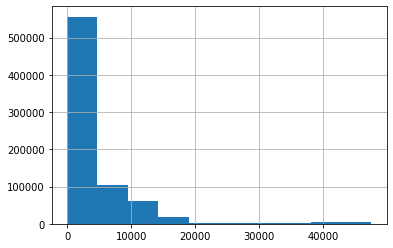

In [29]:
col = 'currentBalance'
df[col].hist();

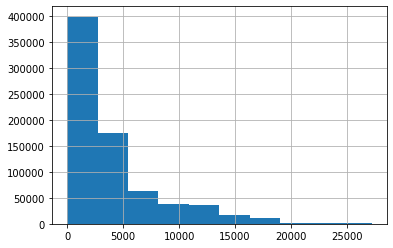

In [30]:
# remove extrem values by quantile 0.98
col = 'currentBalance'
df = df.loc[df[col] <= df[col].quantile(q=0.98)]
df[col].hist();

In [31]:
# check data distribution for bool columns
col = 'cardPresent'
df[col].value_counts()

False    411941
True     333731
Name: cardPresent, dtype: int64

In [32]:
col = 'expirationDateKeyInMatch'
df[col].value_counts()

False    744697
True        975
Name: expirationDateKeyInMatch, dtype: int64

In [33]:
col = 'correctedCVV'
df[col].value_counts()

True     739003
False      6669
Name: correctedCVV, dtype: int64

### Training Model
everything looks ok, build abt for model training

In [34]:
# check dataframe shape
df.shape

(745672, 21)

In [35]:
# generate dummies features
abt = pd.get_dummies(df)

In [36]:
# quick check
print(abt.shape)
abt.head()

(745672, 88)


,creditLimit,availableMoney,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,correctedCVV,transactionDays,currentExpDays,addressChangeDays,transactionDOW,transactionWeek,transactionHour,merchantName_34th BBQ,merchantName_AMC,merchantName_American Airlines,merchantName_Blue Mountain Online Services,merchantName_Blue Mountain eCards,merchantName_Delta Airlines,merchantName_Domino's Pizza,merchantName_EZ Putt Putt,merchantName_Franks Pub,merchantName_Fresh Flowers,merchantName_Fresh Online Services,merchantName_Fresh eCards,merchantName_In-N-Out,merchantName_KFC,merchantName_Lyft,merchantName_Mobile eCards,merchantName_Next Day Online Services,merchantName_Next Day eCards,merchantName_Ray's Fries,merchantName_Regal Cinemas,merchantName_Rodeway Inn,merchantName_South Steakhouse,merchantName_Uber,merchantName_alibaba.com,merchantName_amazon.com,merchantName_apple.com,merchantName_cheapfast.com,merchantName_discount.com,merchantName_ebay.com,merchantName_gap.com,merchantName_oldnavy.com,merchantName_others,merchantName_sears.com,merchantName_staples.com,merchantName_target.com,merchantName_walmart.com,acqCountry_CAN,acqCountry_MEX,acqCountry_PR,acqCountry_US,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_PR,merchantCountryCode_US,posEntryMode_02,posEntryMode_05,posEntryMode_09,posEntryMode_80,posEntryMode_90,posConditionCode_01,posConditionCode_08,posConditionCode_99,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
0,5000.0,5000.0,98.55,0.0,False,False,False,True,518,3001,0,5,32,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,5000.0,5000.0,74.51,0.0,True,False,False,True,577,3246,0,1,41,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5000.0,5000.0,7.47,0.0,False,False,False,True,605,3793,0,1,45,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,5000.0,5000.0,7.47,0.0,False,False,False,True,637,3793,0,5,49,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,5000.0,5000.0,71.18,0.0,True,False,False,True,231,5170,0,3,12,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [37]:
# use a pipeline with SandardScaler and LogisticRegression for classification
# undersample not Fraud transactions by the ratio between fraud transactoins/not fraud transactions from 1/1 to 1/9.
# use f1 score as metric
# output score for CV and score for the test data set

lm_res = {}
for not_fraud_ratio in range(1, 10):
    print(f'1/{not_fraud_ratio}')
    rus = RandomUnderSampler(
        sampling_strategy=1/not_fraud_ratio, random_state=4122)
    X_res, y_res = rus.fit_resample(abt.drop(columns=['isFraud']), abt.isFraud)

    # Load the data
    X, y = X_res, y_res

    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=0.20, random_state=4122)

    # Define the steps of the model
    model = pipeline.Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('lin_reg', linear_model.LogisticRegression(solver='liblinear'))
    ])

    model.fit(X, y)

    # Define a determistic cross-validation procedure
    cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=4122)

    # Compute the F1 values
    scorer = metrics.make_scorer(metrics.f1_score)
    scores = model_selection.cross_val_score(
        model, X_train, y_train, scoring=scorer, cv=cv)

    # Display the average score and it's standard deviation
    print(f'F1 Score of CV: {scores.mean():.3f} (± {scores.std():.3f})')
    lm_res.update({not_fraud_ratio: model})

    # predict test data
    preds = model.predict(X_test)

    print("F1 Score for test: ", metrics.f1_score(y_test, preds))

1/1
F1 Score of CV: 0.698 (± 0.011)
F1 Score for test:  0.7010989010989012
1/2
F1 Score of CV: 0.506 (± 0.015)
F1 Score for test:  0.5024848150193265
1/3
F1 Score of CV: 0.358 (± 0.019)
F1 Score for test:  0.3584229390681004
1/4
F1 Score of CV: 0.252 (± 0.017)
F1 Score for test:  0.24858757062146894
1/5
F1 Score of CV: 0.179 (± 0.020)
F1 Score for test:  0.16724738675958187
1/6
F1 Score of CV: 0.129 (± 0.021)
F1 Score for test:  0.1337579617834395
1/7
F1 Score of CV: 0.098 (± 0.011)
F1 Score for test:  0.1093945720250522
1/8
F1 Score of CV: 0.073 (± 0.010)
F1 Score for test:  0.0794816414686825
1/9
F1 Score of CV: 0.060 (± 0.007)
F1 Score for test:  0.0614596670934699


With the increase of not_fraud_ratio, the average f1-score is decreasing and the std of CV is creasing, indicating potential overfitting. I would choose not_fraud_ratio = 3 for adversarial validation. The reason is in **Conclusion 1** below based on the business analysis.

Adversarial Validation when not_fraud_ratio = 3

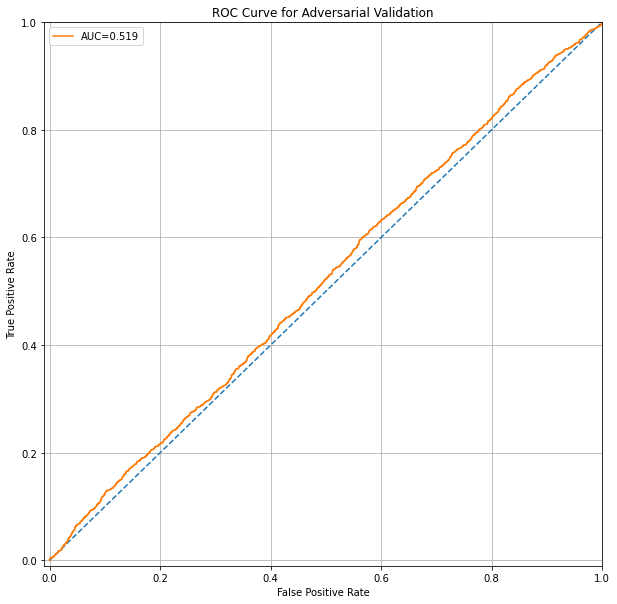

In [39]:
not_fraud_ratio = 3
rus = RandomUnderSampler(
    sampling_strategy=1/not_fraud_ratio, random_state=4122)
X_res, y_res = rus.fit_resample(abt.drop(columns=['isFraud']), abt.isFraud)

# Load the data
X, y = X_res, y_res

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.20, random_state=0)

X_train['label'] = 1
X_test['label'] = 0


tmp_abt = pd.concat([X_train, X_test], ignore_index=True, sort=False)
X, y = tmp_abt.drop(columns=['label']), tmp_abt.label
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.20, random_state=4122)


# Define the steps of the model
model = pipeline.Pipeline([
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LogisticRegression(solver='liblinear'))
])
model.fit(X, y)

# generate fpr, tpr
y_pred_proba = model.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

# create ROC curve and calcluate auc
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 10))
plt.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')

plt.title('ROC Curve for Adversarial Validation')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([-0.01, 1])
plt.ylim([-0.01, 1])
plt.legend()
plt.grid()
plt.show()

The model cannot tell the difference between Train and Test data sets, which means the two data sets are identically distributed.

### Business Insight

revise our business purpose as below.

1. <span style="color:red">One business purpose should reduce loss to avoid fraud transactions</span>, the percentage of **the amount of predicted fraud transaction <span style="color:red">(True Positive)</span>/the amount of fraud transaction** should be high.
2. <span style="color:red">The other business purpose should be less effect on the non-fraud real transactions</span>, the percentage of **the transactions of predicted fraud transactions <span style="color:red">(False Positive)</span>/real transactions** should be low.


In [40]:
# calculate the two percentages using the whole dataset
f1s = {}
val_res = []
for not_fraud_ratio in range(1, 10):
    pred_y = lm_res[not_fraud_ratio].predict(abt.drop(columns=['isFraud']))
    print(not_fraud_ratio)
    f1 = metrics.f1_score(abt.isFraud, pred_y)
    print("F1 Score for the whole dataset: ", f1)
    f1s[not_fraud_ratio] = f1

    real_fraud_trasaction_amount = abt.loc[abt.isFraud ==
                                           True, 'transactionAmount'].sum()
    predit_abt = abt.copy()
    predit_abt['pred_isFraud'] = pred_y
    pred_fraud_transaction_amount = predit_abt.loc[(predit_abt.isFraud == True) & (
        predit_abt.pred_isFraud == True), 'transactionAmount'].sum()

    print(
        f'The Amount of Predicted Fraud Transactions is {pred_fraud_transaction_amount:,},')
    tp_amount_pct = pred_fraud_transaction_amount / real_fraud_trasaction_amount
    print(f'which is {tp_amount_pct:.2%} of total fraud transaction amount.')

    fp_transaction_pct = predit_abt.loc[(predit_abt.isFraud == False) & (
        predit_abt.pred_isFraud == True)].shape[0] / predit_abt.shape[0]
    print(
        f'Wrong predicted transaction pct in Not Fraud Transactions is {fp_transaction_pct:.2%}.')

    res = {'x': not_fraud_ratio, 'tp_amount_pct': tp_amount_pct,
           'fp_transaction_pct': fp_transaction_pct}
    val_res.append(res)
val_res_df = pd.DataFrame(val_res)

1
F1 Score for the whole dataset:  0.059297907417262416
The Amount of Predicted Fraud Transactions is 1,784,931.7000000002,
which is 83.71% of total fraud transaction amount.
Wrong predicted transaction pct in Not Fraud Transactions is 33.50%.
2
F1 Score for the whole dataset:  0.09236361408631902
The Amount of Predicted Fraud Transactions is 1,255,400.5,
which is 58.88% of total fraud transaction amount.
Wrong predicted transaction pct in Not Fraud Transactions is 11.06%.
3
F1 Score for the whole dataset:  0.11030944364277698
The Amount of Predicted Fraud Transactions is 860,303.52,
which is 40.35% of total fraud transaction amount.
Wrong predicted transaction pct in Not Fraud Transactions is 4.85%.
4
F1 Score for the whole dataset:  0.11035701884529185
The Amount of Predicted Fraud Transactions is 576,386.67,
which is 27.03% of total fraud transaction amount.
Wrong predicted transaction pct in Not Fraud Transactions is 2.54%.
5
F1 Score for the whole dataset:  0.10140967252222945
The

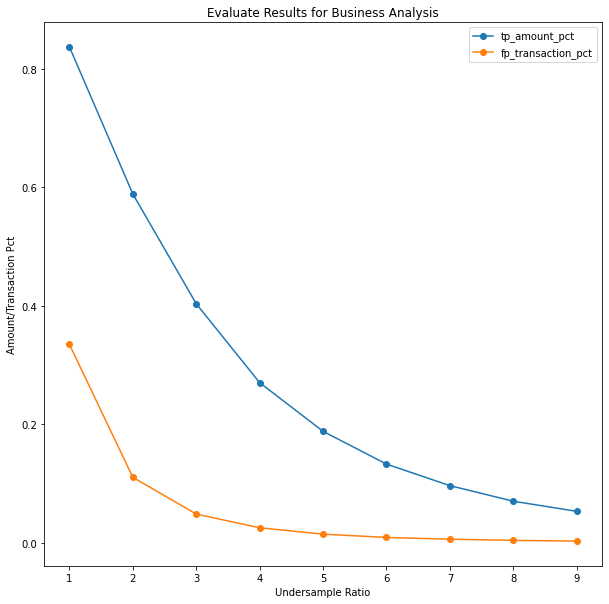

In [41]:
# visulize the result
data1 = list(zip(range(1, 10), val_res_df['tp_amount_pct'].tolist()))
data2 = list(zip(range(1, 10), val_res_df['fp_transaction_pct'].tolist()))
plt.figure(figsize=(10, 10))
plt.plot(*zip(*data1), label='tp_amount_pct', marker='o')
plt.plot(*zip(*data2), label='fp_transaction_pct', marker='o')
plt.title('Evaluate Results for Business Analysis')
plt.xlabel('Undersample Ratio')
plt.ylabel('Amount/Transaction Pct')
plt.legend()
plt.show()

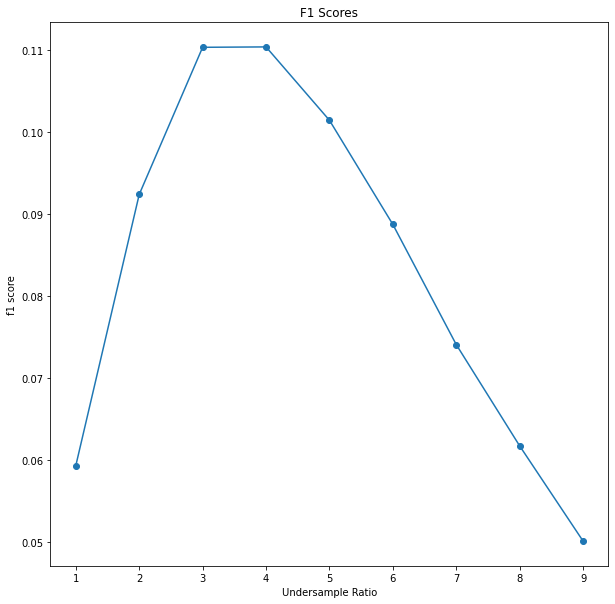

In [42]:
# visulize the result of F1 Score
data = list(zip(f1s.keys(), f1s.values()))
plt.figure(figsize=(10, 10))
plt.plot(*zip(*data), label='tp_amount_pct', marker='o')
plt.title('F1 Scores')
plt.xlabel('Undersample Ratio')
plt.ylabel('f1 score')
plt.show()

### Conclusion 1

I will choose not_fraud_ratio=3 as the resampling strategy because it has higher f1 score.
The TP transaction amounts pct is high at 40.35% of total fraud transaction amount, and FP transaction pct in real transactions is low at 4.85%.

In [ ]:
# save model for the REST API
joblib.dump({
    'model': lm_res[3],
    'selected_features': abt.drop(columns=['isFraud']).columns,
    'high_freq_fraud_merchant_names': high_freq_fraud_mechant_names
}, 'pre_config_data.joblib')

### Comparing with NN
I believe the NN should have better performance. I would choose not_fraud_ratio=3 to train the NN and compare the two methods.

Use Pytorch to train a NN 

In [43]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

not_fraud_ratio = 3
rus = RandomUnderSampler(
    sampling_strategy=1/not_fraud_ratio, random_state=4122)
X_res, y_res = rus.fit_resample(
    abt.drop(columns=['isFraud']), np.array(abt.isFraud.astype(int).tolist()))

# Load the data
X, y = X_res, y_res

scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_scaled, y, test_size=0.20, random_state=4122)


class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        n_hidden1 = 512
        n_hidden2 = 128
        n_output = 1
        self.layer1 = nn.Linear(input_dim, n_hidden1)
        self.layer2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_output = nn.Linear(n_hidden2, n_output)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.sigmoid(self.layer_output(x))
        return x


model = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()
model

Model(
  (layer1): Linear(in_features=87, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=128, bias=True)
  (layer_output): Linear(in_features=128, out_features=1, bias=True)
)

In [44]:
# prepare the whole dataset to test the model later
all_X = abt.drop(columns=['isFraud'])
all_X_scaled = scaler.transform(all_X)

# transform data type
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).float()
X_test = Variable(torch.from_numpy(X_test)).float()
y_test = Variable(torch.from_numpy(y_test)).float()

In [45]:
# train NN
EPOCHS = 400

train_losses = np.zeros((EPOCHS,))
test_losses = np.zeros((EPOCHS,))
models = []


for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train.reshape(-1, 1))

    y_test_pred = model(X_test)
    loss_test = loss_fn(y_test_pred, y_test.reshape(-1, 1))

    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses[epoch] = loss.item()
    test_losses[epoch] = loss_test.item()
    models.append(copy.copy(model))

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [04:21<00:00,  1.53it/s]


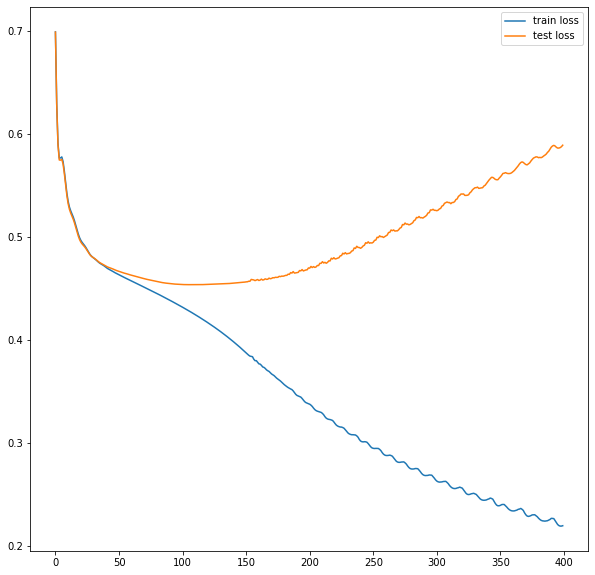

In [46]:
plt.figure(figsize=(10, 10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [47]:
# find the early termination point
np.argmin(test_losses)

108

In [48]:
# use the best model to predict
predictions = models[np.argmin(test_losses)](Variable(torch.from_numpy(all_X_scaled).float()))

In [64]:
# check the business metrics using the whole dataset
cutoff = 0.7975
pred_y = predictions.detach().numpy() >= cutoff

print(not_fraud_ratio)
print("F1 Score for the whole dataset: ",
      metrics.f1_score(abt.isFraud.astype(int), pred_y))

real_fraud_trasaction_amount = abt.loc[abt.isFraud ==
                                       True, 'transactionAmount'].sum()
predit_abt = abt.copy()
predit_abt['pred_isFraud'] = pred_y
pred_fraud_transaction_amount = predit_abt.loc[(predit_abt.isFraud == True) & (
    predit_abt.pred_isFraud == True), 'transactionAmount'].sum()

print(
    f'The Amount of Predicted Fraud Transactions is {pred_fraud_transaction_amount:,},')
tp_amount_pct = pred_fraud_transaction_amount / real_fraud_trasaction_amount
print(f'which is {tp_amount_pct:.2%} of total fraud transaction amount.')

fp_transaction_pct = predit_abt.loc[(predit_abt.isFraud == False) & (
    predit_abt.pred_isFraud == True)].shape[0] / predit_abt.shape[0]
print(
    f'Wrong predicted transaction pct in Not Fraud Transactions is {fp_transaction_pct:.2%}.')

res = {'x': not_fraud_ratio, 'tp_amount_pct': tp_amount_pct,
       'fp_transaction_pct': fp_transaction_pct}
val_res.append(res)

3
F1 Score for the whole dataset:  0.18499759268175253
The Amount of Predicted Fraud Transactions is 1,036,689.4400000001,
which is 48.62% of total fraud transaction amount.
Wrong predicted transaction pct in Not Fraud Transactions is 4.85%.


### Conclusion 2: Comparison between Logistic classification and NN
With the same wrong predicted transaction pct in Not Fraud Transactions, the **pct of total fraud transaction amount** increases <span style="color:red">from 40.35% to 48.62%</span> which could reduce loss about <span style="color:red">$176,385.92</span>. F1 score increases from 0.110 to 0.185. NN wins!

### TODO:
- optimize neutral networks